In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy as sp
from wordcloud import WordCloud, STOPWORDS
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))
        
import surprise
from surprise import Reader
from surprise import Dataset
from surprise.model_selection import train_test_split
import time
from surprise import SVD
from surprise import accuracy
import re
import plotly.express as px
import scipy as sp
from wordcloud import WordCloud, STOPWORDS
from surprise import Reader
from surprise import Dataset
from surprise.model_selection import cross_validate
from surprise import NormalPredictor
from surprise import KNNBasic
from surprise import KNNWithMeans
from surprise import KNNWithZScore
from surprise import KNNBaseline
from surprise import BaselineOnly
from surprise import SVDpp
from surprise import NMF
from surprise import SlopeOne
from surprise import CoClustering
from surprise.accuracy import rmse
from sklearn.model_selection import GridSearchCV
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline  import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder, PolynomialFeatures, Normalizer
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from catboost import CatBoostRegressor
from sklearn.metrics import mean_squared_error

/kaggle/input/edsa-recommender-system-predict/sample_submission.csv
/kaggle/input/edsa-recommender-system-predict/movies.csv
/kaggle/input/edsa-recommender-system-predict/imdb_data.csv
/kaggle/input/edsa-recommender-system-predict/genome_tags.csv
/kaggle/input/edsa-recommender-system-predict/genome_scores.csv
/kaggle/input/edsa-recommender-system-predict/train.csv
/kaggle/input/edsa-recommender-system-predict/test.csv
/kaggle/input/edsa-recommender-system-predict/tags.csv
/kaggle/input/edsa-recommender-system-predict/links.csv


# Table of contents

### [1. Introduction](#introduction)


### [2. Prepocessing](#prep)


### [3. Exploratory Data Analysis](#eda)



### [4. Modelling](#mod)



### [5. Conclusion](#conc)


![image.png](https://manofmany.com/wp-content/uploads/2020/04/Veboli-new-2.jpg)

### [1. Introduction](#introduction)

Recommender systems are systems that are designed to recommend things to the user based on many different factors. These systems predict the most likely product that the user is most likely to purchase and are of interest. Companies like Netflix and Amazon use recommender systems to help their users to identify the correct product or movies for them. 

Recommender systems are an important class of machine learning algorithms that offer relevant suggestions to users. The suggested items are as relevant to the user as possible so that the user can engage with those items: YouTube videos, news articles, online products, movie and series recommendation. 

Items are ranked according to their relevancy, and the most relevant ones are shown to the user. The relevance is determined by the recommender system, mainly based on historical data. For example, If you've recently watched YouTube videos about elephants, then YouTube is going to start showing you many elephant videos with similar titles and themes. 
Recommender systems are generally divided into two main categories: collaborative filtering and content-based systems.

![image.png](https://miro.medium.com/max/690/1*G4h4fOX6bCJhdmbsXDL0PA.png)
 
Both users and service providers have benefited from these kinds of systems. Intelligent algorithms can help viewers find great titles from tens of thousands of options. This notebook will construct a recommendation algorithm based on content and collaborative filtering, capable of accurately predicting how a user will rate a movie they have not yet viewed based on their historic preferences.

Providing an accurate and robust solution will have immense economic potential, with users of the system being exposed to content they would like to view or purchase - generating revenue and platform affinity.



#### [1.1. Import Data](#import)

In [2]:
data_folder = '/kaggle/input/edsa-recommender-system-predict/'
#data_folder = 'C:/Users/ADMIN/Desktop/unsupervised_project/'
train_df = pd.read_csv(data_folder + 'train.csv')
test_df = pd.read_csv(data_folder + 'test.csv')
tags_df = pd.read_csv(data_folder + 'tags.csv')
movies_df = pd.read_csv(data_folder + 'movies.csv')
links_df = pd.read_csv(data_folder + 'links.csv')
imdb_df = pd.read_csv(data_folder + 'imdb_data.csv')
genome_tags = pd.read_csv(data_folder + 'genome_tags.csv')
genome_score = pd.read_csv(data_folder + 'genome_scores.csv')

### [2. Preprocessing](#prep)

### [3. Exploratory Data Analysis](#eda)

Exploratory data analysis is an approach to analyzing data sets to summarize their main characteristics, often with visual methods. EDA is the critical process of performing initial investigations on data to discover patterns, to spot anomalies, to test hypothesis and to check assumptions with the help of summary statistics and graphical representations.
A statistical model can be used or not, but primarily EDA is for seeing what the data can tell us beyond the formal modelling or hypothesis testing task.

It is a good practice to understand the data first and try to gather as many insights from it. EDA is all about making sense of data in hand, before getting them dirty with it, which will be done below 

In [3]:
## Creating a summary stats function
def Summary(df):
    return df.info()

The info() function is used to print a concise summary of a DataFrame. This method prints information about a DataFrame including the index dtype and column dtypes, non-null values and memory usage.

In [4]:
Summary(train_df)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000038 entries, 0 to 10000037
Data columns (total 4 columns):
 #   Column     Dtype  
---  ------     -----  
 0   userId     int64  
 1   movieId    int64  
 2   rating     float64
 3   timestamp  int64  
dtypes: float64(1), int64(3)
memory usage: 305.2 MB


In [5]:
Summary(test_df)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000019 entries, 0 to 5000018
Data columns (total 2 columns):
 #   Column   Dtype
---  ------   -----
 0   userId   int64
 1   movieId  int64
dtypes: int64(2)
memory usage: 76.3 MB


In [6]:
Summary(tags_df)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1093360 entries, 0 to 1093359
Data columns (total 4 columns):
 #   Column     Non-Null Count    Dtype 
---  ------     --------------    ----- 
 0   userId     1093360 non-null  int64 
 1   movieId    1093360 non-null  int64 
 2   tag        1093344 non-null  object
 3   timestamp  1093360 non-null  int64 
dtypes: int64(3), object(1)
memory usage: 33.4+ MB


In [7]:
Summary(movies_df)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62423 entries, 0 to 62422
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   movieId  62423 non-null  int64 
 1   title    62423 non-null  object
 2   genres   62423 non-null  object
dtypes: int64(1), object(2)
memory usage: 1.4+ MB


In [8]:
Summary(links_df)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62423 entries, 0 to 62422
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   movieId  62423 non-null  int64  
 1   imdbId   62423 non-null  int64  
 2   tmdbId   62316 non-null  float64
dtypes: float64(1), int64(2)
memory usage: 1.4 MB


In [9]:
Summary(imdb_df)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27278 entries, 0 to 27277
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   movieId        27278 non-null  int64  
 1   title_cast     17210 non-null  object 
 2   director       17404 non-null  object 
 3   runtime        15189 non-null  float64
 4   budget         7906 non-null   object 
 5   plot_keywords  16200 non-null  object 
dtypes: float64(1), int64(1), object(4)
memory usage: 1.2+ MB


In [10]:
Summary(genome_tags)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1128 entries, 0 to 1127
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   tagId   1128 non-null   int64 
 1   tag     1128 non-null   object
dtypes: int64(1), object(1)
memory usage: 17.8+ KB


In [11]:
Summary(genome_score)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15584448 entries, 0 to 15584447
Data columns (total 3 columns):
 #   Column     Dtype  
---  ------     -----  
 0   movieId    int64  
 1   tagId      int64  
 2   relevance  float64
dtypes: float64(1), int64(2)
memory usage: 356.7 MB


Most of the DataFrames have a Dtype of int64 and float64, which is an indication for numeric values. However, some DataFrames also have Dtype of an object, which is an indication of non-numeric character. The DataFrames which have a Dtype include tags_df; movies_df; imdb_df; and genome_df. 

In [12]:
len(train_df)

10000038

In [13]:
# To find the number of times a user rated a movie, we create a data frame with the count by userId
train_user = pd.DataFrame(
    train_df['userId'].value_counts()).reset_index()
train_user.rename(columns={'index':'userId','userId':'count'},
                  inplace=True)
train_user.head()


,userId,count
0,72315,12952
1,80974,3680
2,137293,3588
3,33844,3208
4,20055,3050


### Visualizing common users

In [14]:
# Grouping the users within a certain range aided us in determining the common userId's and the new ones.
group_one = train_user.loc[(train_user['count'] > 0) & 
            (train_user['count'] < 50),
            'userId'].value_counts().sum()
group_two = train_user.loc[(train_user['count'] >= 50) & 
            (train_user['count'] < 500),
            'userId'].value_counts().sum()
group_three = train_user.loc[(train_user['count'] >= 500) & 
            (train_user['count'] < 1000),
            'userId'].value_counts().sum()
group_four = train_user.loc[(train_user['count'] >= 1000) & 
            (train_user['count'] < 1500),
            'userId'].value_counts().sum()
group_five = train_user.loc[(train_user['count'] >= 1500),
            'userId'].value_counts().sum()

In [15]:
# To give us insight in the spread, we used figures to determine the spread.
trial_error = np.array([['group_one', group_one,
                         'ratings_count between 1 and 50'],
                        ['group_two', group_two,
                         'ratings_count between 50 and 500'],
                        ['group_three', group_three,
                         'ratings_count between 500 and 1000'],
                        ['group_four', group_four,
                         'ratings_count between 1000 and 1500'],
                        ['group_five', group_five,
                         'ratings_count greater than 1500']])
trial_error_df = pd.DataFrame({'group': trial_error[:, 0],
                               'userId_grouping': trial_error[:, 1],
                               'explanation': trial_error[:, 2]})
fig = px.bar(trial_error_df,
             x=trial_error_df["group"],
             y=trial_error_df["userId_grouping"],
             color=trial_error_df["group"],
             title='Grouped Rating Distribustion')
fig.show()
trial_error_df


,group,userId_grouping,explanation
0,group_one,110010,ratings_count between 1 and 50
1,group_two,50973,ratings_count between 50 and 500
2,group_three,1338,ratings_count between 500 and 1000
3,group_four,159,ratings_count between 1000 and 1500
4,group_five,61,ratings_count greater than 1500


The user Id's are grouped by the rating counts in a grouping range illustrated in the DataFrame above.  In the Grouped Rating Distribution bar graph, it is visually displayed that there is unequal distribution.  The distribution is skewed to the left, with the majority of the user ids in the rating count range between 1 and 50. At the same time, the last group has only a value count of 61, which is a significant difference from group one with a value count of 110 010.

### Visualizing the dataframes

In [16]:
# Created a Data Frame outlining the size of our data
dataframes = ['train_df', 'test_df', 'tags_df', 'imdb_df',
              'links_df', 'movies_df', 'genome_tags', 'genome_score']
sizes = [len(train_df), len(test_df), len(tags_df),
         len(imdb_df), len(links_df), len(movies_df),
         len(genome_tags), len(genome_score)]
total_size_df = pd.DataFrame(list(zip(dataframes, sizes)),
                             columns=['dataframe', 'sizes'])
total_size_df

,dataframe,sizes
0,train_df,10000038
1,test_df,5000019
2,tags_df,1093360
3,imdb_df,27278
4,links_df,62423
5,movies_df,62423
6,genome_tags,1128
7,genome_score,15584448


In [17]:
new_row = {'dataframe': 'other', 'sizes': 180530}
total_size_df = total_size_df.append(new_row,
                                     ignore_index=True)
total_size_df

,dataframe,sizes
0,train_df,10000038
1,test_df,5000019
2,tags_df,1093360
3,imdb_df,27278
4,links_df,62423
5,movies_df,62423
6,genome_tags,1128
7,genome_score,15584448
8,other,180530


In [18]:
total_size_df = total_size_df[total_size_df['sizes'] > 100000]
total_size_df

,dataframe,sizes
0,train_df,10000038
1,test_df,5000019
2,tags_df,1093360
7,genome_score,15584448
8,other,180530


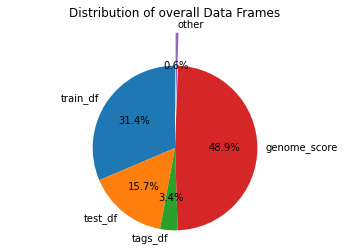

In [19]:
explodeTuple = (0.0, 0.0, 0.0, 0.0, 0.4)
fig1, ax1 = plt.subplots()
ax1.pie(total_size_df['sizes'].values,
        labels=total_size_df['dataframe'].values,
        startangle=90, autopct='%1.1f%%',
        explode=explodeTuple)
ax1.axis('equal')
plt.title('Distribution of overall Data Frames')
plt.show()

In [20]:
len_list = [['train_df', len(train_df)], ['tags_df', len(tags_df)],
            ['imdb_df', len(imdb_df)], ['links_df', len(links_df)],
            ['movies_df', len(movies_df)],
            ['genome_tags', len(genome_tags)],
            ['genome_score', len(genome_score)]]
len_df = pd.DataFrame(len_list,
                      columns=['Dataset', 'Size'])
fig = px.bar(len_df, x=len_df['Dataset'],
             y=len_df['Size'],
             color=len_df['Dataset'],
             title='Distribution of overall Data Frames')
fig.show()


### Visualizing the null values for each dataframe

In [21]:
# Obtaining the total null values in each Data Frames columns
train_count = pd.DataFrame(train_df.isnull().sum())
test_count = pd.DataFrame(test_df.isnull().sum())
tags_count = pd.DataFrame(tags_df.isnull().sum())
movies_count = pd.DataFrame(movies_df.isnull().sum())
links_count = pd.DataFrame(links_df.isnull().sum())
imdb_count = pd.DataFrame(imdb_df.isnull().sum())
genomet_count = pd.DataFrame(genome_tags.isnull().sum())
genomes_count = pd.DataFrame(genome_score.isnull().sum())

In [22]:
train_count

,0
userId,0
movieId,0
rating,0
timestamp,0


In [23]:
test_count

,0
userId,0
movieId,0


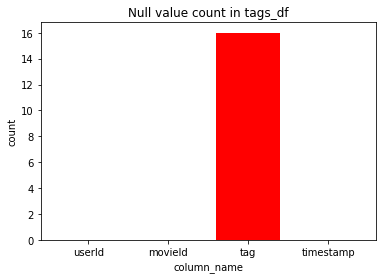

,userId,movieId,tag,timestamp
860902,121710,33826,NaN,1221450908
976395,141727,123,NaN,1199450867
976396,141727,346,NaN,1199451946
976400,141727,1184,NaN,1199452261
976407,141727,1785,NaN,1199452006
976408,141727,2194,NaN,1199450677
976410,141727,2691,NaN,1199451002
976418,141727,4103,NaN,1199451920
976420,141727,4473,NaN,1199451040
976422,141727,4616,NaN,1199452441


In [24]:
plt.bar(tags_count.index,
        tags_count.values.reshape(len(tags_count), ),
        color='red')
plt.xlabel('column_name')
plt.ylabel('count')
plt.title('Null value count in tags_df')
plt.show()
tags_df[tags_df.isnull().any(axis=1)]

In [25]:
movies_count

,0
movieId,0
title,0
genres,0


In [26]:
links_count

,0
movieId,0
imdbId,0
tmdbId,107


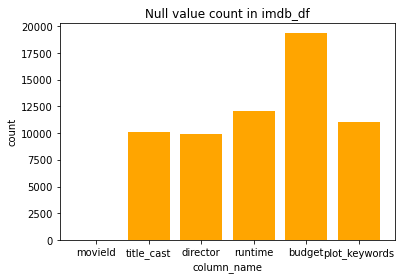

In [27]:
plt.bar(imdb_count.index,
        imdb_count.values.reshape(len(imdb_count), ),
        color='orange')
plt.xlabel('column_name')
plt.ylabel('count')
plt.title('Null value count in imdb_df')
plt.show()

In [28]:
genomet_count

,0
tagId,0
tag,0


In [29]:
genomes_count

,0
movieId,0
tagId,0
relevance,0


In [30]:
def user_ratings_count(df, n):
    plt.figure(figsize=(14,7))
    data = df['userId'].value_counts().head(n)
    ax = sns.barplot(x = data.index, y = data, order= data.index, palette='CMRmap', edgecolor="black")
    for p in ax.patches:
        ax.text(p.get_x() + p.get_width()/2., p.get_height(), '%d' % int(p.get_height()), fontsize=11, ha='center', va='bottom')
    plt.title(f'Top {n} Users by Number of Ratings', fontsize=14)
    plt.xlabel('User ID')
    plt.ylabel('Number of Ratings')
    print("Combined number of ratings:\t",df['userId'].value_counts().head(n).sum(),
         "\nTotal number of movies:\t\t", df['movieId'].nunique())
    plt.show()

Combined number of ratings:	 38970 
Total number of movies:		 48213


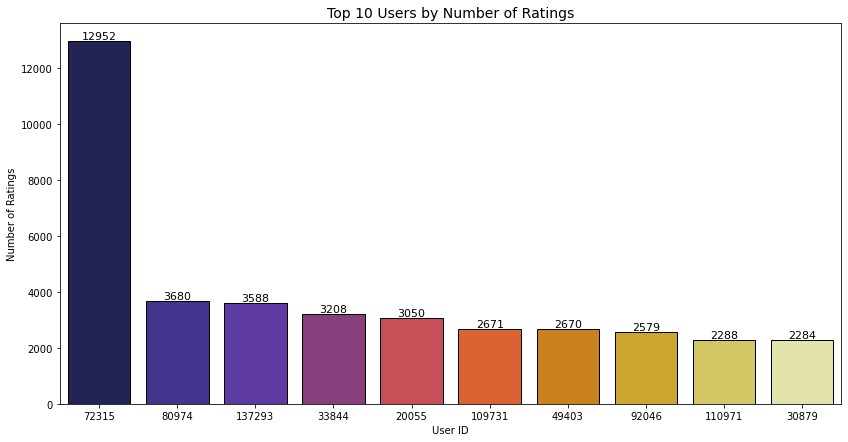

In [31]:
user_ratings_count(train_df,10)

Removing user with userId 72315 because he is an outlier

Combined number of ratings:	 28296 
Total number of movies:		 45844


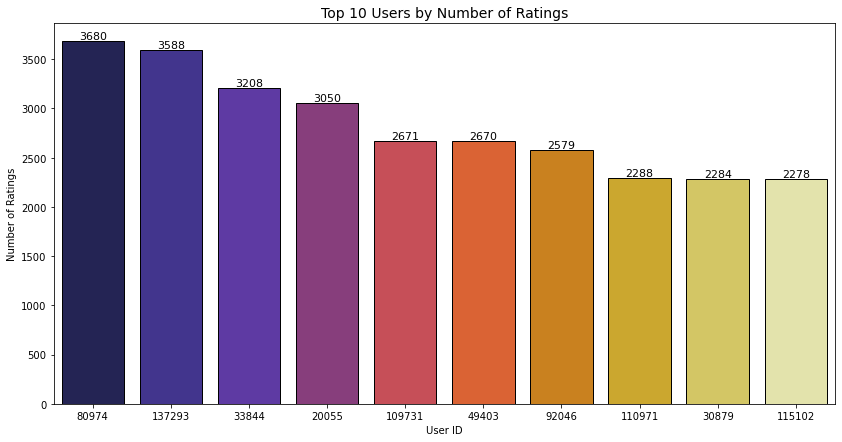

In [32]:
user_ratings_count(train_df[train_df['userId'] !=72315],10)

### Exploring Movie Genres

In [33]:
genres = pd.DataFrame(movies_df['genres'].
                      str.split("|").
                      tolist(),
                      index=movies_df['movieId']).stack()
genres = genres.reset_index([0, 'movieId'])
genres.columns = ['movieId', 'Genre']


In [34]:
genres.head()

,movieId,Genre
0,1,Adventure
1,1,Animation
2,1,Children
3,1,Comedy
4,1,Fantasy


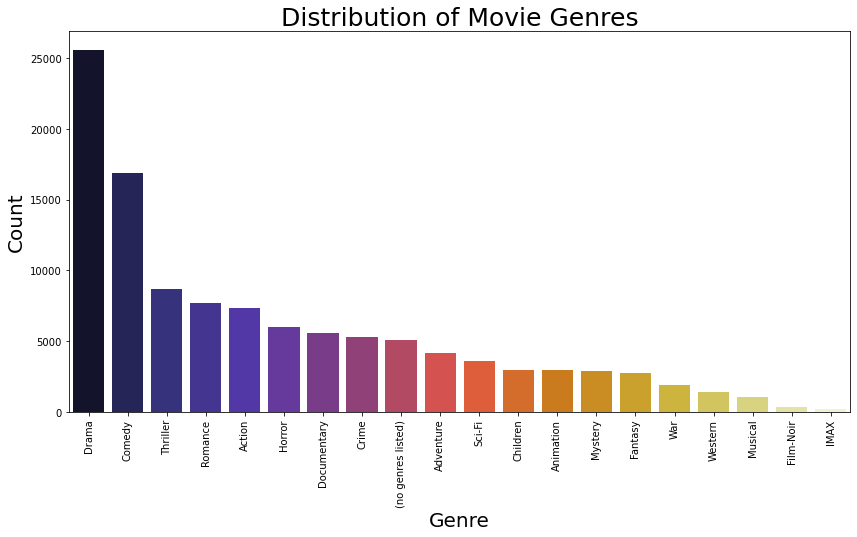

In [35]:
fig, ax = plt.subplots(figsize=(14, 7))
sns.countplot(x='Genre',
              data=genres,
              palette='CMRmap',
              order=genres['Genre'].
              value_counts().index)
plt.xticks(rotation=90)
plt.xlabel('Genre', size=20)
plt.ylabel('Count', size=20)
plt.title('Distribution of Movie Genres', size=25)
plt.show()

In [36]:
movies=pd.merge(train_df, movies_df,on='movieId',how='inner')
movies.head()

,userId,movieId,rating,timestamp,title,genres
0,5163,57669,4.0,1518349992,In Bruges (2008),Comedy|Crime|Drama|Thriller
1,87388,57669,3.5,1237455297,In Bruges (2008),Comedy|Crime|Drama|Thriller
2,137050,57669,4.0,1425631854,In Bruges (2008),Comedy|Crime|Drama|Thriller
3,120490,57669,4.5,1408228517,In Bruges (2008),Comedy|Crime|Drama|Thriller
4,50616,57669,4.5,1446941640,In Bruges (2008),Comedy|Crime|Drama|Thriller


In [37]:
def top_n_plot_by_ratings(df,column, n):
    plt.figure(figsize=(14,7))
    data = df[str(column)].value_counts().head(n)
    ax = sns.barplot(x = data.index, y = data, order= data.index, palette='CMRmap', edgecolor="black")
    for p in ax.patches:
        ax.text(p.get_x() + p.get_width()/2., p.get_height(), '%d' % int(p.get_height()), fontsize=11, ha='center', va='bottom')
    plt.title(f'Top {n} {column.title()} by Number of Ratings', fontsize=14)
    plt.xlabel(column.title())
    plt.ylabel('Number of Ratings')
    plt.xticks(rotation=90)
    plt.show()

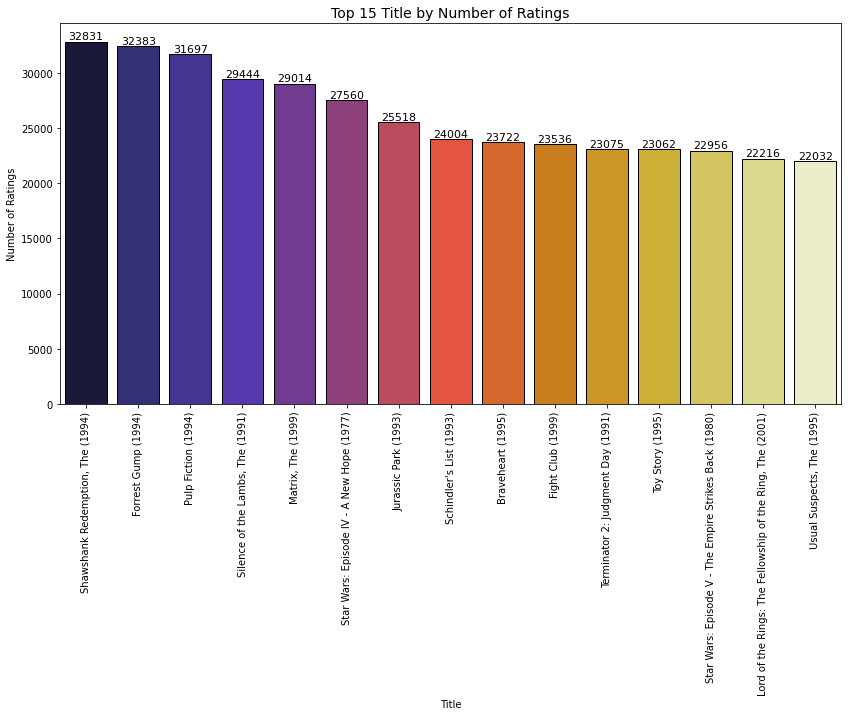

In [38]:
top_n_plot_by_ratings(movies,'title',15)

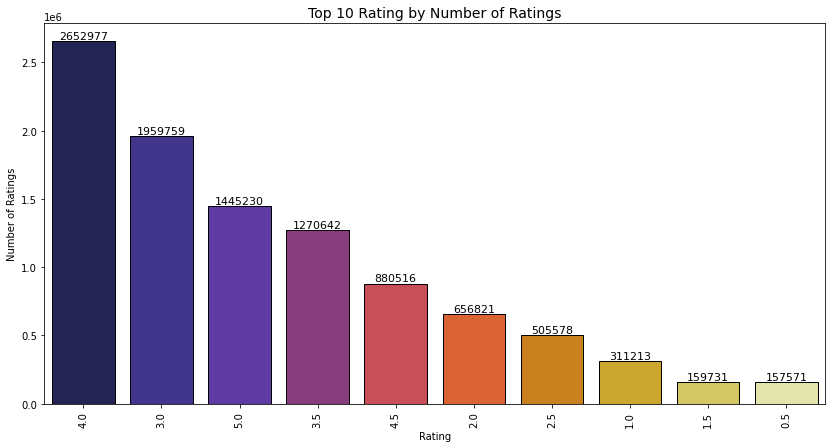

In [39]:
top_n_plot_by_ratings(movies,'rating',10)

In [40]:
full_movies = pd.merge(movies,imdb_df,on='movieId',how='inner')
full_movies.head()

,userId,movieId,rating,timestamp,title,genres,title_cast,director,runtime,budget,plot_keywords
0,5163,57669,4.0,1518349992,In Bruges (2008),Comedy|Crime|Drama|Thriller,Elizabeth Berrington|Rudy Blomme|Olivier Bonjo...,Martin McDonagh,107.0,"$15,000,000",dwarf|bruges|irish|hitman
1,87388,57669,3.5,1237455297,In Bruges (2008),Comedy|Crime|Drama|Thriller,Elizabeth Berrington|Rudy Blomme|Olivier Bonjo...,Martin McDonagh,107.0,"$15,000,000",dwarf|bruges|irish|hitman
2,137050,57669,4.0,1425631854,In Bruges (2008),Comedy|Crime|Drama|Thriller,Elizabeth Berrington|Rudy Blomme|Olivier Bonjo...,Martin McDonagh,107.0,"$15,000,000",dwarf|bruges|irish|hitman
3,120490,57669,4.5,1408228517,In Bruges (2008),Comedy|Crime|Drama|Thriller,Elizabeth Berrington|Rudy Blomme|Olivier Bonjo...,Martin McDonagh,107.0,"$15,000,000",dwarf|bruges|irish|hitman
4,50616,57669,4.5,1446941640,In Bruges (2008),Comedy|Crime|Drama|Thriller,Elizabeth Berrington|Rudy Blomme|Olivier Bonjo...,Martin McDonagh,107.0,"$15,000,000",dwarf|bruges|irish|hitman


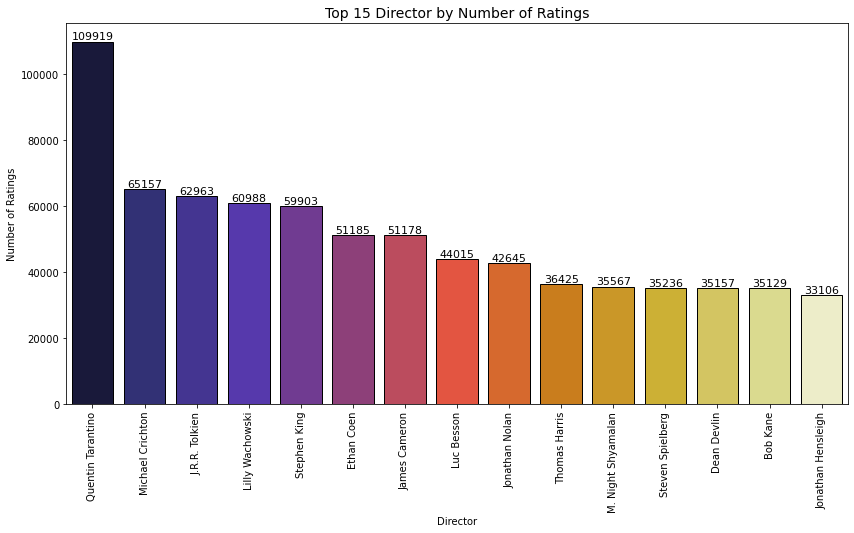

In [41]:
top_n_plot_by_ratings(full_movies,'director',15)

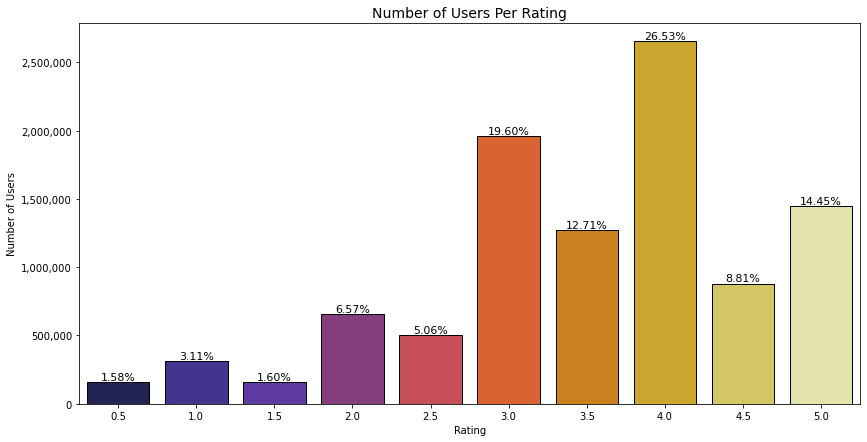

In [42]:
movieRatingDistGroup = train_df['rating'].value_counts().sort_index().reset_index()
fig, ax = plt.subplots(figsize=(14,7))
sns.barplot(data=movieRatingDistGroup, x='index', y='rating', palette="CMRmap", edgecolor="black", ax=ax)
ax.set_xlabel("Rating")
ax.set_ylabel('Number of Users')
ax.set_yticklabels(['{:,}'.format(int(x)) for x in ax.get_yticks().tolist()])
total = float(movieRatingDistGroup['rating'].sum())
for p in ax.patches:
    height = p.get_height()
    ax.text(p.get_x()+p.get_width()/2., height+350, '{0:.2%}'.format(height/total), fontsize=11, ha="center", va='bottom')
plt.title('Number of Users Per Rating', fontsize=14)
plt.show()

In [43]:
def count_directors(df, count = 10):
    """
    Function to count the most common dircetors in a DataFrame:
    Parameters
    ----------
        df (DataFrame): input dataframe containing imdb metadata
        count (int): filter directors with fewer than count films
        
    Returns
    -------
        directors (DataFrame): output DataFrame
    Examples
    --------
        >>> df = pd.DataFrame({'imdbid':[0,1,2,3,4,5], 'director': [A,B,A,C,B]})
        >>> count_directors(df, count = 1)
            |index|director|count|
            |0|A|2|
            |1|B|2|
            |2|C|1|
    """
    directors = pd.DataFrame(df['director'].value_counts()).reset_index()
    directors.columns = ['director', 'count']
    # Lets only take directors who have made 10 or more movies otherwise we will have to analyze 11000 directors
    directors = directors[directors['count']>=count]
    return directors.sort_values('count', ascending = False)

In [44]:
directors = count_directors(imdb_df)
directors.head()

,director,count
0,See full summary,28
2,Woody Allen,26
1,Luc Besson,26
3,Stephen King,24
4,William Shakespeare,19


In [45]:
def feature_count(df, column):
    plt.figure(figsize=(14,7))
    ax = sns.barplot(x = df[f'{column}'], y= df['count'], palette='brg')
    plt.title(f'Number of Movies Per {column}', fontsize=14)
    plt.xlabel(f'{column}')
    plt.ylabel('Count')
    plt.xticks(rotation=90)
    plt.show()

Filtering out see full summary because that is not the name of a sensible human being

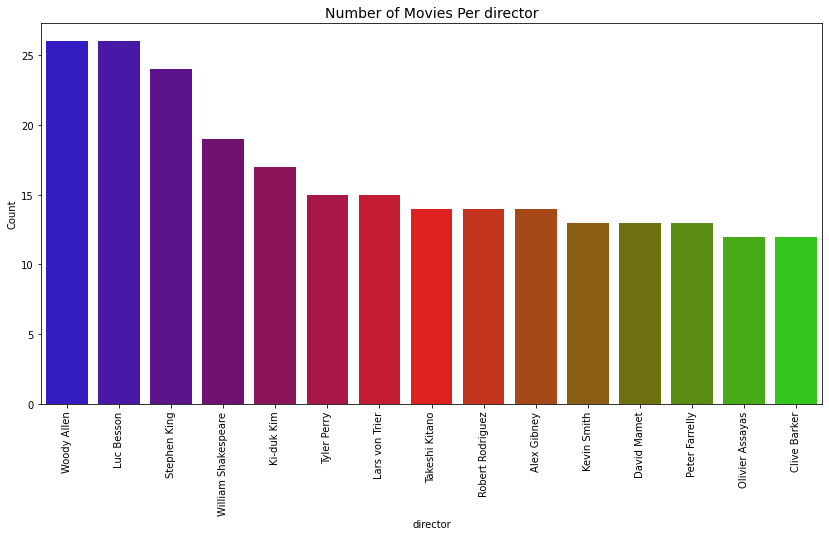

In [46]:
feature_count(directors[directors['director'] !='See full summary'].head(15), 'director')

### Word Clouds

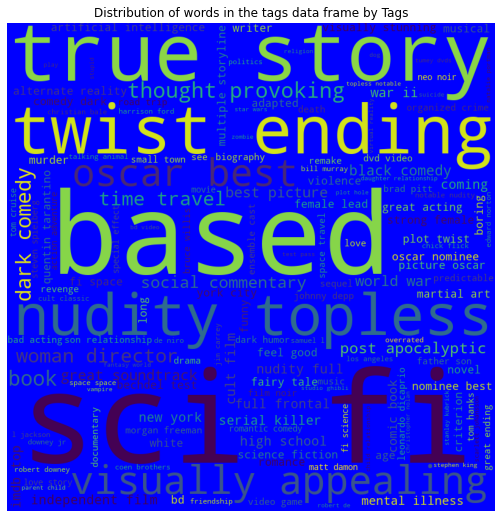

In [47]:
comment_words = ''
stopwords = set(STOPWORDS)

# iterate through the csv file
for val in tags_df['tag']:

    # typecaste each val to string
    val = str(val)

    # split the value
    tokens = val.split()

    # Converts each token into lowercase
    for i in range(len(tokens)):
        tokens[i] = tokens[i].lower()

    comment_words += " ".join(tokens)+" "
  
wordcloud = WordCloud(width=800, height=800,
                      background_color='blue',
                      stopwords=stopwords,
                      min_font_size=10).generate(comment_words)

# plot the WordCloud image
plt.figure(figsize=(14, 7), facecolor=None)
plt.imshow(wordcloud)
plt.axis("off")
plt.title('Distribution of words in the tags data frame by Tags')
plt.tight_layout(pad=0)

plt.show()


In [48]:
value_count = pd.DataFrame(tags_df['tag'].
                           value_counts()).reset_index()
value_count.rename(columns = {'index': 'genre', 'tag': 'count'},
                   inplace = True)

In [49]:
value_count.head()

,genre,count
0,sci-fi,8330
1,atmospheric,6516
2,action,5907
3,comedy,5702
4,surreal,5326


### Publishing Years

In [50]:
dates = []
for title in movies_df['title']:
    if title[-1] == " ":
        year = title[-6: -2]
        try:
            dates.append(int(year))
        except:
            dates.append(9999)
    else:
        year = title[-5: -1]
        try:
            dates.append(int(year))
        except:
            dates.append(9999)

movies_df['Publish Year'] = dates


In [51]:
dates = []
for title in movies_df['title']:
    if title[-1] == " ":
        year = title[-6: -2]
        try:
            dates.append(int(year))
        except:
            dates.append(9999)
    else:
        year = title[-5: -1]
        try:
            dates.append(int(year))
        except:
            dates.append(9999)

movies_df['Publish Year'] = dates



In [52]:
len(movies_df)

62423

In [53]:
movies_df[movies_df['Publish Year'] == 9999].head()

,movieId,title,genres,Publish Year
15036,79607,"Millions Game, The (Das Millionenspiel)",Action|Drama|Sci-Fi|Thriller,9999
18789,98063,Mona and the Time of Burning Love (Mona ja pal...,Drama,9999
25387,123619,Terrible Joe Moran,(no genres listed),9999
26284,125571,The Court-Martial of Jackie Robinson,(no genres listed),9999
26309,125632,In Our Garden,(no genres listed),9999


In [54]:
movies_df[(movies_df['Publish Year'] > 1888) &
          (movies_df['Publish Year'] < 2021)]

,movieId,title,genres,Publish Year
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,1995
1,2,Jumanji (1995),Adventure|Children|Fantasy,1995
2,3,Grumpier Old Men (1995),Comedy|Romance,1995
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance,1995
4,5,Father of the Bride Part II (1995),Comedy,1995
...,...,...,...,...
62418,209157,We (2018),Drama,2018
62419,209159,Window of the Soul (2001),Documentary,2001
62420,209163,Bad Poems (2018),Comedy|Drama,2018
62421,209169,A Girl Thing (2001),(no genres listed),2001


In [55]:
dataset = pd.DataFrame(movies_df['Publish Year'].
                       value_counts()).reset_index()
dataset.rename(columns={'index': 'year', 'Publish Year': 'count'},
               inplace=True)
dataset.head(50)

,year,count
0,2015,2513
1,2016,2488
2,2014,2406
3,2017,2374
4,2013,2173
5,2018,2034
6,2012,1978
7,2011,1838
8,2009,1724
9,2010,1691


In [56]:
year_dataset = dataset[(dataset['year']>1888) & (dataset['year']<2021)].sort_values(by='count',ascending=False).head(50)
year_dataset.head()

,year,count
0,2015,2513
1,2016,2488
2,2014,2406
3,2017,2374
4,2013,2173


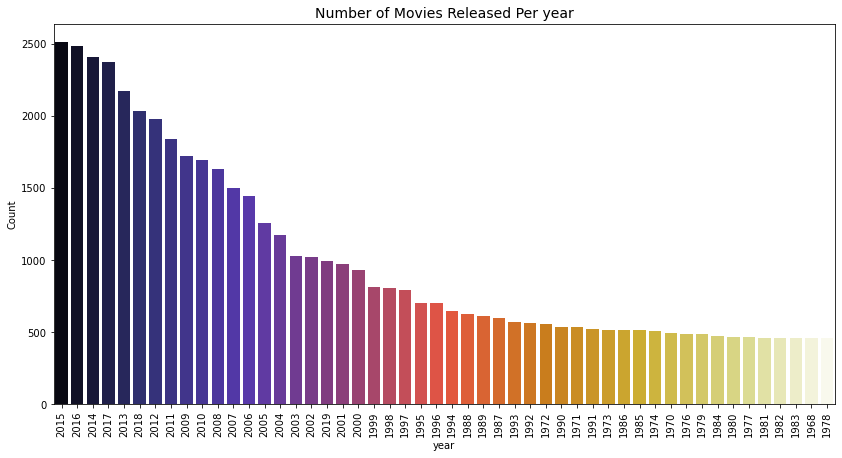

In [57]:
plt.figure(figsize=(14,7))
ax = sns.barplot(x = year_dataset['year'], y= year_dataset['count'], order=year_dataset['year'], palette='CMRmap')
#for p in ax.patches:
#        ax.text(p.get_x() + p.get_width()/2., p.get_height(), '%d' % int(p.get_height()), fontsize=11, ha='center', va='bottom')
plt.title(f'Number of Movies Released Per year', fontsize=14)
plt.xlabel('year')
plt.ylabel('Count')
plt.xticks(rotation=90)
plt.show()

In [58]:
# Plotting the Publish years
fig = plt.bar(x=dataset['year'],
             y=dataset['count'],
             color=dataset['year'],
             title='Movies released per Publish Year')
fig.show()

TypeError: bar() missing 1 required positional argument: 'height'